HMM Personal Project

This project aims to use the Hidden Markov Model to identify different regimes in a Time Series.
The HMM model will be done from scratch, and the results will be validated using external libraries.
An effort is made to use as little external libraries as possible.

Imports

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Synthetic parameters used to create the time series

In [112]:
#Number of States
N = 3

#Number of observations
T = 400

#initial probability distribution, three state markov chain
pi = [0.3,0.5,0.2]

#transition probability matrix
A= np.array([[0.9,0.05,0.05],[0.1,0.7,0.2],[0.05,0.05,0.9]])
print(A)

#set seed
np.random.seed(1342)

[[0.9  0.05 0.05]
 [0.1  0.7  0.2 ]
 [0.05 0.05 0.9 ]]


Lets assume we are looking at coin tosses, and three coins are available.

State 1: Coin 1: tail biased, 0,7 tails, 0.3 heads\
State 2: Coin 2: Fair Coin: 0.5, tails, 0.5 heads\
State 3: Coin 3: head biased, 0.2 tails, 0.8 heads


Say we gain 1 dollar when we hit heads, and loose 1 dollar with tails, we can create a realization of this multi-state random walk

In [113]:
#coin variables
dbias_tails = 0.7
fbias_tails = 0.5
ubias_tails = 0.2

#Probability distribution of the observations at each state (b emission matrix)
b = np.array([[dbias_tails, 1-dbias_tails],[fbias_tails, 1-fbias_tails],[ubias_tails, 1-ubias_tails]])

In [114]:
#set the initial state
rand = np.random.uniform()
lhs = 0

#Use the random uniform variable and the distribution to find which state we are starting in
for i in pi:
    if rand <= i + lhs:
        state = pi.index(i)
        break
    lhs += i

#States array
states = [state]

#Realization array
realization = []
running = 0
observations = []

for iteration in range(T):
    #we know which state we start in (which coin we have), we flip the coin
    u = np.random.uniform()
    match state:
        case 0:
            if u < dbias_tails:
                running = running - 1
                realization.append(running)
                observations.append(0)
            else:
                running = running + 1
                realization.append(running)
                observations.append(1)
        case 1:
            if u < fbias_tails:
                running = running - 1
                realization.append(running)
                observations.append(0)
            else:
                running = running + 1
                realization.append(running)
                observations.append(1)
        case 2:
            if u < ubias_tails:
                running = running - 1
                realization.append(running)
                observations.append(0)
            else:
                running = running + 1
                realization.append(running)
                observations.append(1)
    
    #Once the flip is done and the score is updated, we may or may not change states
    u2 = np.random.uniform()
    distr = A[state,:]
    lhs = 0
    for j in distr:
        if u2 <= j + lhs:
            state = np.where(distr==j)[0][0]
            break
        lhs += j
    states.append(state)

observations = np.array(observations)

Plot realization and states

3


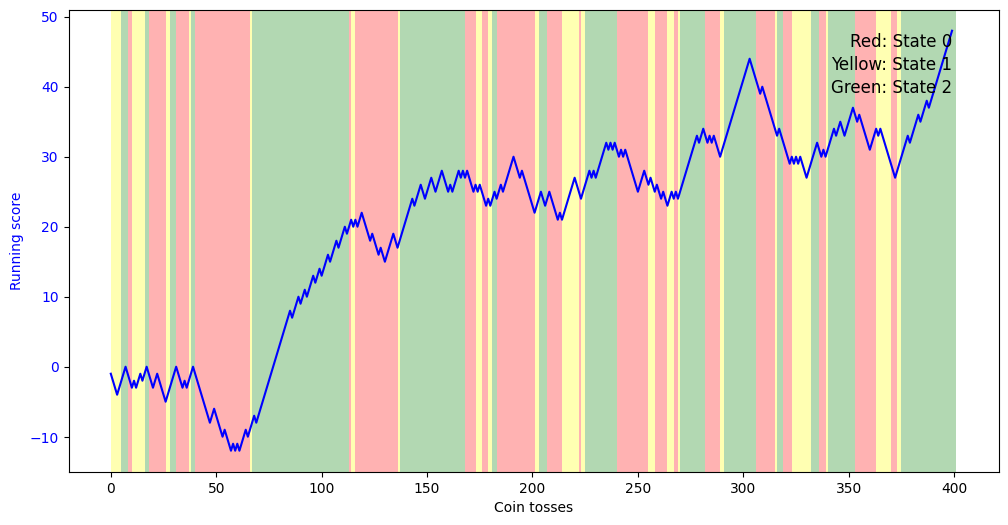

In [115]:
fig, ax1 = plt.subplots(figsize = (12,6))
print(N)

ax1.plot(realization, color='blue', label='Realization')
ax1.set_xlabel('Coin tosses')
ax1.set_ylabel('Running score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

for i in range(len(states)):
    if states[i] == 0:
        ax1.axvspan(i, i+1, facecolor='red', alpha=0.3)
    elif states[i] == 1:
        ax1.axvspan(i, i+1, facecolor='yellow', alpha=0.3)
    elif states[i] == 2:
        ax1.axvspan(i, i+1, facecolor='green', alpha=0.3)

ax1.text(0.95, 0.95, 'Red: State 0', transform=ax1.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
ax1.text(0.95, 0.90, 'Yellow: State 1', transform=ax1.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
ax1.text(0.95, 0.85, 'Green: State 2', transform=ax1.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')

plt.show()


Now that we have our realization, we will try to find the states and the parameters using the HMM model\

In practice this would be as if we observed someone play the coin-flip game for 1000 flips and are now trying to infer the model from these observations. We do not know the state sequence or the transition probabilities.

To do so, we use the forward-backward algorithm, or Baum-Welch algorithm, which is an EM algorithm.\
For this, we need an initial estimate of the A matrix and emission probabilites.

The forward algorithm: It allows to find the probability of being in state j after seeing the first to observations, given the HMM parameters

#### Initialization:

$$
\alpha_{1}(j)=\pi_{j} b_{j}\left(o_{1}\right) \quad 1 \leq j \leq N
$$

#### Recursion

$$
\alpha_{t}(j)=\sum_{i=1}^{N} \alpha_{t-1}(i) a_{i j} b_{j}\left(o_{t}\right) ; \quad 1 \leq j \leq N, 1<t \leq T
$$

#### Termination

$$
P(O \mid \lambda)=\sum_{i=1}^{N} \alpha_{T}(i)
$$

In [116]:
#this is our probability matrix
def compute_forward(N,T,A,b,pi,observations):
    forward = np.zeros((N, T))

    for j in range(N):
        forward[j,0] =  pi[j]*b[j,observations[0]]

    for t in range(1,T):
        for n in range(N):
            #np.ones for the sum, forward[]*A[][] multiplies each state by the transition probability to state n, and b[]
            #gives the probability of seeing observation t when in state n
            forward[n,t] = np.sum(forward[:,t-1]*A[:,n]*b[n,observations[t]])

    forwardprob = np.sum(forward[:,T-1])
    return forward,forwardprob


Now we need to do the backward algorithm: The backward probability $\beta$ is the probability of seeing the observations from time $t+1$ to the end, given that we are in state $i$ at time $t$ (and given the automaton $\lambda$ ) [1]:

$$
\begin{equation*}
\beta_{t}(i)=P\left(o_{t+1}, o_{t+2} \ldots o_{T} \mid q_{t}=i, \lambda\right)
\end{equation*}
$$

#### Initialization

$$
\beta_{T}(i) = 1, \quad 1 \leq i \leq N
$$

#### Recursion

$$
\beta_{t}(i) = \sum_{j=1}^{N} a_{i j} b_{j}\left(o_{t+1}\right) \beta_{t+1}(j), \quad 1 \leq i \leq N, \; 1 \leq t < T
$$

#### Termination

$$
P(O \mid \lambda) = \sum_{j=1}^{N} \pi_{j} b_{j}\left(o_{1}\right) \beta_{1}(j)
$$

In [117]:
def compute_backward(N,T,A,b,pi,observations):

    #this is our probability matrix
    backward = np.zeros((N, T))

    for i in range(N):
        backward[i,T-1] =  1

    for t in reversed(range(0,T-1)):
        for n in range(N):
            #np.ones for the sum, backward[]*A[][] multiplies each state by the transition probability to state n, and b[]
            #gives the probability of seeing observation t+1 when in state n        
            backward[n,t] = np.sum(backward[:,t+1]*A[n,:]*b[:,observations[t+1]])

    backwardprob = np.sum(pi*b[:,observations[0]]*backward[:,0])

    return backward,backwardprob

We will need to know the probability of being in state $j$ at time $t$, which we will call $\gamma_{t}(j)$ :

$$
\begin{equation*}
\gamma_{t}(j)=P\left(q_{t}=j \mid O, \lambda\right) \tag{A.25}
\end{equation*}
$$

Once again, we will compute this by including the observation sequence in the probability:

$$
\begin{equation*}
\gamma_{t}(j)=\frac{P\left(q_{t}=j, O \mid \lambda\right)}{P(O \mid \lambda)} \tag{A.26}
\end{equation*}
$$

This just the product of the forward probability and the backward probability:

$$
\begin{equation*}
\gamma_{t}(j)=\frac{\alpha_{t}(j) \beta_{t}(j)}{P(O \mid \lambda)} \tag{A.27}
\end{equation*}
$$


In [118]:
def compute_gamma(forward,backward,forwardprob):
    gamma = forward*backward/forwardprob
    return gamma

Let's begin by seeing how to estimate $\hat{a}_{i j}$ by a variant of simple maximum likelihood estimation:

$$
\begin{equation*}
\hat{a}_{i j}=\frac{\text { expected number of transitions from state } i \text { to state } j}{\text { expected number of transitions from state } i} \tag{A.16}
\end{equation*}
$$

How do we compute the numerator? Here's the intuition. Assume we had some estimate of the probability that a given transition $i \rightarrow j$ was taken at a particular point in time $t$ in the observation sequence. If we knew this probability for each particular time $t$, we could sum over all times $t$ to estimate the total count for the transition $i \rightarrow j$.

More formally, let's define the probability $\xi_{t}$ as the probability of being in state $i$ at time $t$ and state $j$ at time $t+1$, given the observation sequence and of course the model:

$$
\begin{equation*}
\xi_{t}(i, j)=P\left(q_{t}=i, q_{t+1}=j \mid O, \lambda\right) \tag{A.17}
\end{equation*}
$$

To compute $\xi_{t}$, we first compute a probability which is similar to $\xi_{t}$, but differs in including the probability of the observation; note the different conditioning of $O$ from bq. A. 17 :

$$
\begin{equation*}
\text { not-quite- } \xi_{t}(i, j)=P\left(q_{t}=i, q_{t+1}=j, O \mid \lambda\right) \tag{A.18}
\end{equation*}
$$

To produce not-quite- $\xi_{t}$ as follows:

$$
\begin{equation*}
\text { not-quite- } \xi_{t}(i, j)=\alpha_{t}(i) a_{i j} b_{j}\left(o_{t+1}\right) \beta_{t+1}(j) \tag{A.19}
\end{equation*}
$$

To compute $\xi_{t}$ from not-quite- $\xi_{t}$, we follow the laws of probability and divide by $P(O \mid \lambda)$, since

$$
\begin{equation*}
P(X \mid Y, Z)=\frac{P(X, Y \mid Z)}{P(Y \mid Z)} \tag{A.20}
\end{equation*}
$$

The probability of the observation given the model is simply the forward probability of the whole utterance (or alternatively, the backward probability of the whole utterance):

$$
\begin{equation*}
P(O \mid \lambda)=\sum_{j=1}^{N} \alpha_{t}(j) \beta_{t}(j) \tag{A.21}
\end{equation*}
$$

So, the final equation for $\xi_{t}$ is

$$
\begin{equation*}
\xi_{t}(i, j)=\frac{\alpha_{t}(i) a_{i j} b_{j}\left(o_{t+1}\right) \beta_{t+1}(j)}{\sum_{j=1}^{N} \alpha_{t}(j) \beta_{t}(j)} \tag{A.22}
\end{equation*}
$$

In [119]:
def comptute_xi(N,T,A,b,observations,forward,backward,forwardprob):
    nqxi = np.zeros((T,N,N))

    for t in range(0,T-1):
        for i in range(N):
            for j in range(N):
                nqxi[t,i,j] = forward[i,t]*A[i,j]*b[j,observations[t+1]]*backward[j,t+1]

    xi = nqxi/forwardprob
    return xi

The expected number of transitions from state $i$ to state $j$ is then the sum over all $t$ of $\xi$. For our estimate of $a_{i j}$, we just need one more thing: the total expected number of transitions from state $i$. We can get this by summing over all transitions out of state $i$. Here's the final formula for $\hat{a}_{i j}$ :

$$
\begin{equation*}
\hat{a}_{i j}=\frac{\sum_{t=1}^{T-1} \xi_{t}(i, j)}{\sum_{t=1}^{T-1} \sum_{k=1}^{N} \xi_{t}(i, k)} \tag{A.23}
\end{equation*}
$$

In [120]:
def compute_ahat(xi,N):
    a_hat = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            a_hat[i,j] = np.sum(xi[:-1,i,j])/np.sum(xi[:-1,i,:])
        
    return a_hat

We are ready to compute $b$. For the numerator, we sum $\gamma_{t}(j)$ for all time steps $t$ in which the observation $o_{t}$ is the symbol $v_{k}$ that we are interested in. For the denominator, we sum $\gamma_{t}(j)$ over all time steps $t$. The result is the percentage of the times that we were in state $j$ and saw symbol $v_{k}$ (the notation $\sum_{t=1 \text { s.t. } O_{t}=v_{k}}^{T}$ means "sum over all $t$ for which the observation at time $t$ was $v_{k}$ "):

$$
\begin{equation*}
\hat{b}_{j}\left(v_{k}\right)=\frac{\sum_{t=1 \text { s.t. } O_{t}=v_{k}}^{T} \gamma_{t}(j)}{\sum_{t=1}^{T} \gamma_{t}(j)} \tag{A.28}
\end{equation*}
$$

In [121]:
#In our case, b is a 3*2 array
def compute_bhat(N,gamma,observations):
    bhat = np.zeros((N,2))
    tailsid = np.where(observations == 0)[0]
    headsid = np.where(observations == 1)[0]

    for j in range(N):
        bhat[j,0]= np.sum(gamma[j,tailsid])/np.sum(gamma[j,:])
        bhat[j,1]= np.sum(gamma[j,headsid])/np.sum(gamma[j,:])
    
    return bhat





We can now use the expectation maximimization algorithm. We start with an estimate of A,b,and pi.


In [122]:
#As an initial guess, we can assume some persistence in the model
A_hat = np.array([[1/3,1/3,1/3],
                  [1/3,1/3,1/3],
                  [1/3,1/3,1/3]])

#We can also start by assuming there is an up-bias, down bias and neutral state
b_hat = np.array([[0.6,0.4],
                  [0.5,0.5],
                  [0.4,0.6]])

#We will also assume the probability of starting in each state is equal
pi_hat = np.array([1/3,1/3,1/3])

EM Algorithm:

In [123]:
def EM(N,T,A_hat,b_hat,pi_hat,observations):
    iterations = 3000
    threshold = 0.000001
    prev_log_likelihood = -np.inf
    logr = []

    for i in range(iterations):
        #Expectation step
        forw, forwprob = compute_forward(N,T,A_hat,b_hat,pi_hat,observations)
        back,backprob = compute_backward(N,T,A_hat,b_hat,pi_hat,observations)
        gam = compute_gamma(forw,back,forwprob)

        xi_hat = comptute_xi(N,T,A_hat,b_hat,observations,forw,back,forwprob)

        #M-step
        A_hat = compute_ahat(xi_hat,N)
        b_hat = compute_bhat(N,gam,observations)
        #pi_hat = gam[:,0]

        # Calculate the log-likelihood
        log_likelihood = np.log(forwprob)
        logr.append(log_likelihood)

        # Check for convergence
        if np.abs(log_likelihood - prev_log_likelihood) < threshold:
            print(f"Converged after {i} iterations")
            break

        prev_log_likelihood = log_likelihood


    print("THE ESTIMATE FOR A IS")
    print(np.round(A_hat,2))
    print("THE ESTIMATE FOR b IS")
    print(np.round(b_hat,2))


    plt.plot(logr)
    plt.title("log-likelihood")
    plt.show()



Converged after 1726 iterations
THE ESTIMATE FOR A IS
[[0.77 0.18 0.05]
 [0.52 0.48 0.  ]
 [0.07 0.   0.93]]
THE ESTIMATE FOR b IS
[[0.4  0.6 ]
 [1.   0.  ]
 [0.18 0.82]]


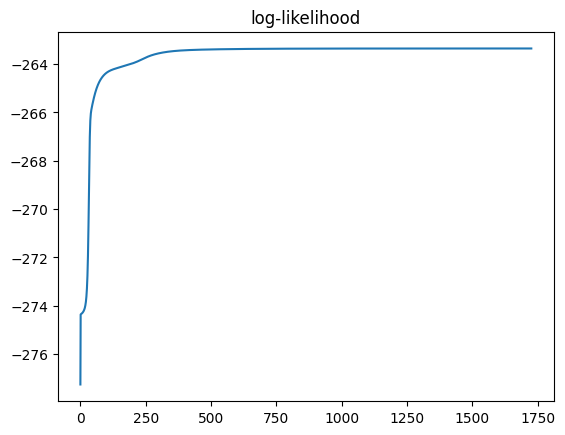

In [124]:
EM(N,T,A_hat,b_hat,pi_hat,observations)